# Implement

In [1]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
from project import Projection
from algorithm_CQ import CQ_split_acceptance
from upper_level import optimize_phase2
from problem import Problem
from prettytable import PrettyTable
from utils import visualize_trajectory_generic, visualize_complete_system

import matplotlib.pyplot as plt

import itertools
import pandas as pd

# Define

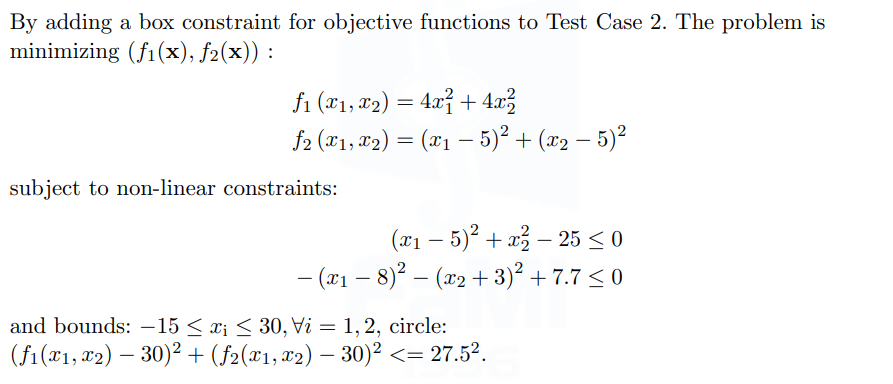

In [2]:
def f(x):
    return np.array([
        4*x[0]**2 + 4*x[1]**2,
        (x[0] - 5)**2 + (x[1] - 5)**2
    ])


#--------------- C --------------------#
def c1(x):
    return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x):
    return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7


#--------------- Q --------------------#
def q1(y):
    return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2

def q_plus(y):
    center = 50.0
    radius_sq = 50**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 2
bounds_x = Bounds([-15,-15],[30, 30])

cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2


# Phase 1

In [4]:
# ==========================================
# 2. KHỞI TẠO ĐỐI TƯỢNG VÀ GIẢI CẤP 1
# ==========================================

print("=== BẮT ĐẦU VÍ DỤ MINH HỌA ESP 2 CẤP ===")

# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian(f)], C=[], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

# --- Điểm khởi tạo Phase 1 ---
x_init = np.array([-10.0, -10.0]) # Trong C, nhưng vi phạm Q+

print("\n--- PHASE 1: TÌM ĐIỂM KHẢ THI (CQ ALGORITHM) ---")
# Chạy thuật toán CQ có sẵn của bạn
x_feasible, x_hist, f_hist, z_proj_hist = CQ_split_acceptance(
    f=prob.objective_func,
    jac_f=prob.jacobian,
    proj_C=prob.proj_C,
    proj_Qplus=prob.proj_Qplus,
    x0=x_init,
    gamma=0.00055, 
    max_iter=300,
    tol=1e-4
)

print(f"-> Điểm khả thi tìm được sau Phase 1: {x_feasible}")

=== BẮT ĐẦU VÍ DỤ MINH HỌA ESP 2 CẤP ===

--- PHASE 1: TÌM ĐIỂM KHẢ THI (CQ ALGORITHM) ---
Khởi tạo: x0: [-10. -10.]
Chiếu lên C được: x: [ 4.0789 -4.5249]


100%|██████████| 300/300 [00:01<00:00, 173.65it/s]

+-----+------------------------+---------+--------------------------+------------------------+----------+-----------+
|  k  | x_new                  | gamma_k | y                        | z_proj                 |   e_x    |    e_f    |
+-----+------------------------+---------+--------------------------+------------------------+----------+-----------+
|  0  | [ 4.078929, -4.524861] | 0.0006  | [148.448121,  91.571354] | [96.061745, 69.450338] | 1.337433 | 56.865382 |
|  10 | [ 3.795912, -3.160143] | 0.0000  | [97.581818, 68.037765]   | [96.7533  , 67.723682] | 0.001362 |  0.886053 |
|  20 | [ 3.795597, -3.151649] | 0.0000  | [97.357801, 67.899969]   | [96.770575, 67.678046] | 0.000498 |  0.627761 |
|  30 | [ 3.795462, -3.147861] | 0.0000  | [97.258242, 67.838545]   | [96.778371, 67.657408] | 0.000275 |  0.512921 |
|  40 | [ 3.795383, -3.1456  ] | 0.0000  | [97.198933, 67.801897]   | [96.783039, 67.645035] | 0.000179 |  0.444492 |
|  50 | [ 3.79533 , -3.144046] | 0.0000  | [97.158214, 6

Đang xử lý dữ liệu và tạo đồ thị tổng hợp...


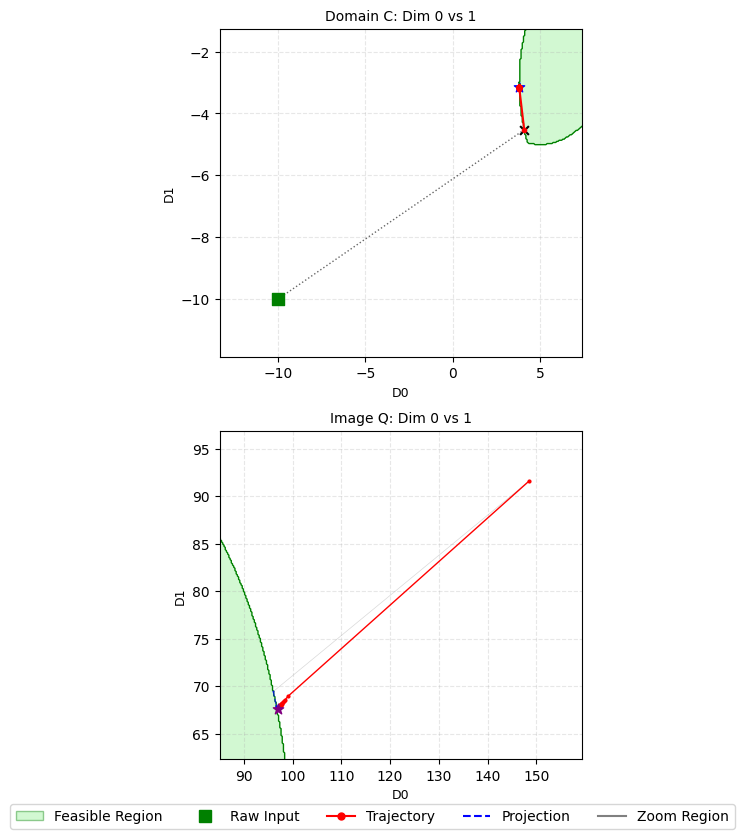

In [4]:
_ = visualize_complete_system(
    x_hist, f_hist, z_proj_hist,
    cons_C, cons_Qplus,
    x0=x_init,   
)

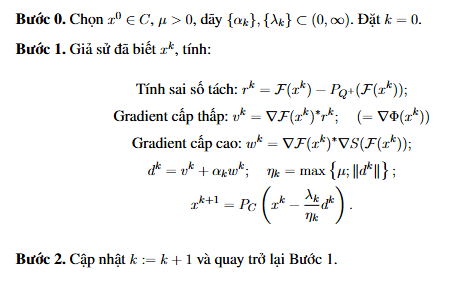

# Test

In [5]:
expo_alpha = 0.35
expo_lambda = 0.75
init_params = 0.5

In [6]:
x_final, path_x = optimize_phase2(
    prob=prob,
    x_feasible=x_feasible,  
    u_star=u_star, 
    max_iter=2000,
    mu=0.1,
    expo_alpha=expo_alpha,
    expo_lambda=expo_lambda,
    init_params=init_params,
    verbose=True
)

+------+---------+----------+-----------------+----------+---------+
|    k | Alpha_k | Step_len |          x_curr |  S(F(x)) |  Gap Q+ |
+------+---------+----------+-----------------+----------+---------+
|    0 |  0.5000 |   0.0002 | [ 3.795,-3.136] | 140.4235 |  0.1482 |
|   50 |  0.1263 |   0.0006 | [ 5.281,-0.673] | 111.4208 | 13.3518 |
|  100 |  0.0994 |   0.0005 |   [5.27 ,0.201] | 111.1539 | 11.2727 |
|  150 |  0.0864 |   0.0004 |   [5.239,0.175] | 112.5260 |  9.9215 |
|  200 |  0.0781 |   0.0004 |   [5.219,0.157] | 113.4097 |  9.0524 |
|  250 |  0.0723 |   0.0004 |   [5.204,0.144] | 114.0476 |  8.4257 |
|  300 |  0.0678 |   0.0003 |   [5.193,0.134] | 114.5385 |  7.9437 |
|  350 |  0.0643 |   0.0003 |   [5.184,0.126] | 114.9351 |  7.5547 |
|  400 |  0.0614 |   0.0003 |   [5.176,0.119] | 115.2619 |  7.2341 |
|  450 |  0.0589 |   0.0003 |   [5.17 ,0.113] | 115.5416 |  6.9600 |
|  500 |  0.0568 |   0.0003 |   [5.164,0.108] | 115.7818 |  6.7245 |
|  550 |  0.0549 |   0.0002 |   [5

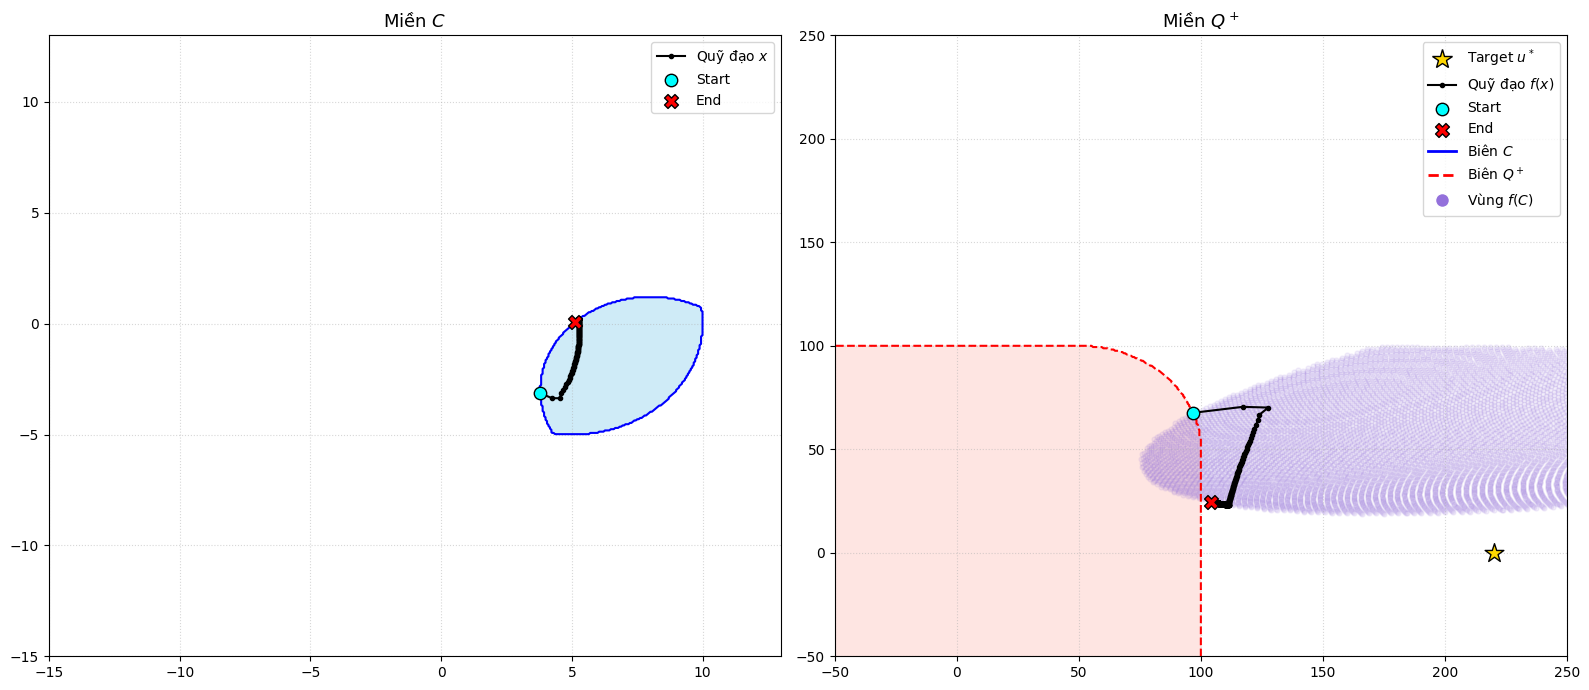

In [7]:
 visualize_trajectory_generic(
        path_x=path_x,
        f_func=f,
        cons_C=cons_C,
        cons_Qplus=cons_Qplus,
        u_star=u_star, 
        x_limits=(-15, 13), 
        y_limits=(-50, 250),
        titles=("Miền $C$", "Miền $Q^+$")
    )

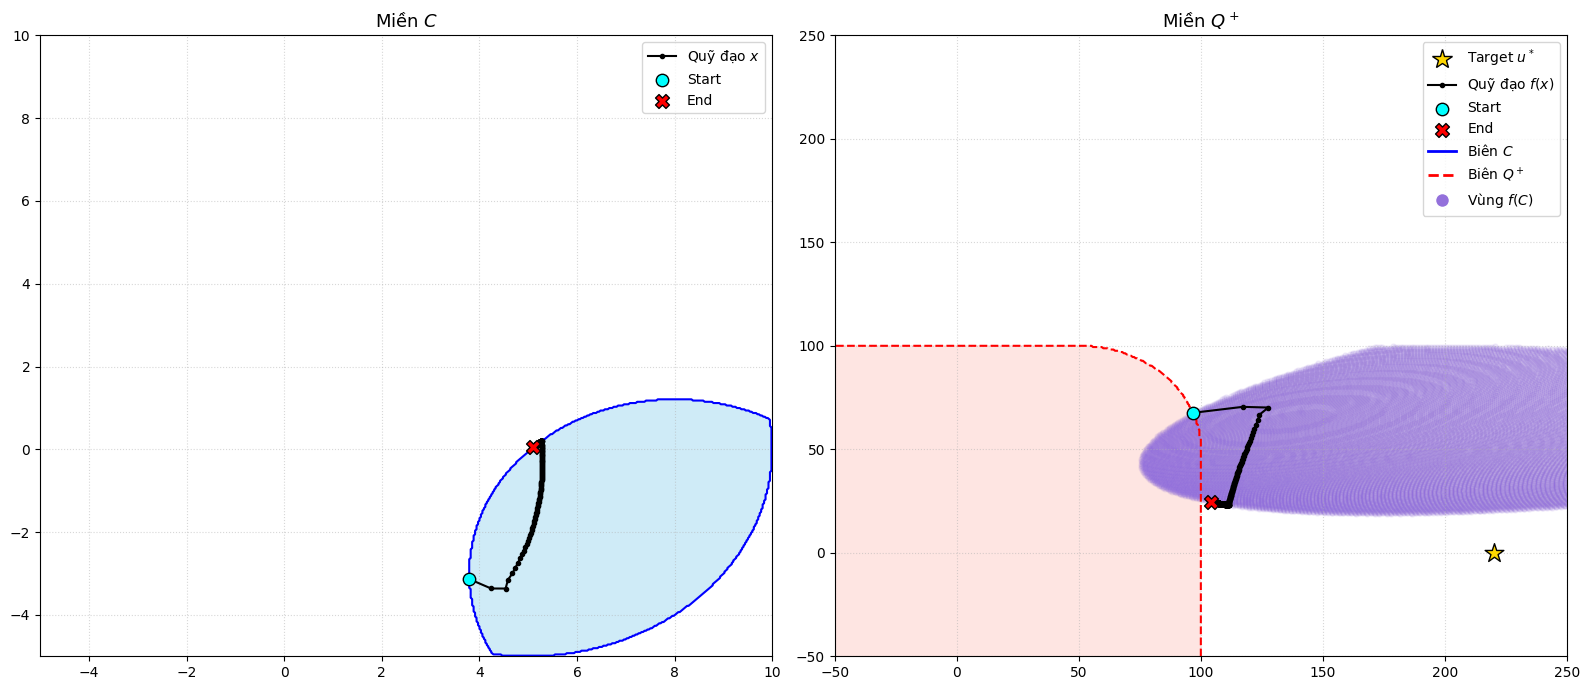

In [10]:
 visualize_trajectory_generic(
        path_x=path_x,
        f_func=f,
        cons_C=cons_C,
        cons_Qplus=cons_Qplus,
        u_star=u_star, 
        x_limits=(-5, 10), 
        y_limits=(-50, 250),
        titles=("Miền $C$", "Miền $Q^+$")
    )

---

In [11]:
x = [-0.1239, -0.0699]

In [12]:
f(x)

array([ 0.0809, 51.9582])